# Feature Engineering: Principal Component Analysis for Dimensionality Reduction

In this notebook, principal component analysis (PCA) of the dataset is tested to see if dimensionality reduction is possible for this dataset. PCA is useful as it can reduce the data input into the model during training without sacrificing model accuracy. From the exploratory data analysis, correlated variables were found and pca will be applied to these variables. 

PCA, much like the machine learning models will be fitted to the training dataset and then tested on the test and validation sets. 

The R^2 score will be used for measuring accuracy - this is a standard metric in regression. The model used is a random forest regressor.

In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

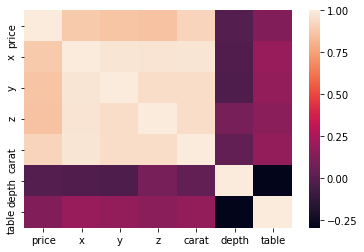

In [2]:
read_dir = os.path.join(os.getcwd(),'datasets')
diamonds_df = pd.read_csv(os.path.join(read_dir,'diamonds.csv'))
correlation_df = diamonds_df[['price', 'x','y','z','carat','depth','table']]
corr_matrix = correlation_df.corr()
sns.heatmap(corr_matrix)

**This heatmap shows that x,y,z and carat dimensions are highly correlated - this makes dimensionality reduction through pca more feasible and useful. Since there is very little correlation between price and table and depth, they might not be very usefule features. Therefore we should remove depth as it adds data without adding information.**

In [16]:
train = pd.read_csv(os.path.join(read_dir,'train.csv'))
pca_list=['table','x','y','z','carat']
index = train.keys()
index_x = [ind for ind in index if ind!= 'price' and ind!= 'index']
y_train = train['price']
X_train = train[index_x]

val = pd.read_csv(os.path.join(read_dir,'val.csv'))
y_val = val['price']
X_val = val[index_x]

In [19]:
X_trainpca = X_train[pca_list]
X_valpca = X_val[pca_list]
pca= PCA(n_components=2)
X_tpca = pca.fit_transform(X_trainpca)
print('Explained Variance {}'.format(pca.explained_variance_ratio_))

Explained Variance [0.78485144 0.18822577]


**The variation in the 2 dimensions accounts for almost all variation in the size dimensions of the diamond - allowing for a 44% decrease in data required (from 9 features to 5).**

In [21]:
X_tnpca = X_train[[i for i in X_train.keys() if i not in pca_list]]
X_trainin = np.concatenate((np.array(X_tpca), np.array(X_tnpca)), axis=1)
train_pca = np.concatenate((np.array(y_train).reshape(-1,1),X_trainin),axis=1)
train_pcadf = pd.DataFrame(train_pca)
train_pcadf = train_pcadf.rename(columns={0:'price',1:'dimension 1',2:'dimension 2',3: 'color',4:'clarity',5:'cut'})
train_pcadf.to_csv(os.path.join(read_dir,'train_pca.csv' ))

In [22]:
X_valpca = X_val[pca_list]
X_valpca = pca.transform(X_valpca)
X_vnpca = X_val[[i for i in X_train.keys() if i not in pca_list]]
X_valin = np.concatenate((np.array(X_valpca), np.array(X_vnpca)), axis=1)
val_pca = np.concatenate((np.array(y_val).reshape(-1,1),X_valin),axis=1)
val_pcadf = pd.DataFrame(val_pca)
val_pcadf = val_pcadf.rename(columns={0:'price',1:'dimension 1',2:'dimension 2',3: 'color',4:'clarity',5:'cut'})
val_pcadf.to_csv(os.path.join(read_dir,'val_pca.csv' ))

In [23]:
test = pd.read_csv(os.path.join(read_dir,'test.csv' ))
y_test = test['price']
X_test = test[index_x]
X_testpca = X_test[pca_list]
X_testpca = pca.transform(X_testpca)
X_testnpca = X_test[[i for i in X_train.keys() if i not in pca_list]]
X_testin = np.concatenate((np.array(X_testpca), np.array(X_testnpca)), axis=1)
test_pca = np.concatenate((np.array(y_test).reshape(-1,1),X_testin),axis=1)
test_pcadf = pd.DataFrame(test_pca)
test_pcadf = test_pcadf.rename(columns={0:'price',1:'dimension 1',2:'dimension 2', 3: 'color',4:'clarity',5:'cut'})
test_pcadf.to_csv(os.path.join(read_dir,'test_pca.csv' ))

In [24]:
model_RFD = RandomForestRegressor()
model_RFD.fit(X_trainin,y_train)
y_pred_RFD = model_RFD.predict(X_valin)
mse_RFD = mean_squared_error(y_val,y_pred_RFD)
rmse_RFD = np.sqrt(mse_RFD)
r2D = r2_score(y_val, y_pred_RFD)

C:\Users\Rajeev\Anaconda3\envs\development\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [25]:
model_RF = RandomForestRegressor()
model_RF.fit(X_train,y_train)
y_pred_RF = model_RF.predict(X_val)
mse_RF = mean_squared_error(y_val,y_pred_RF)
rmse_RF = np.sqrt(mse_RF)
r2 = r2_score(y_val, y_pred_RF)


C:\Users\Rajeev\Anaconda3\envs\development\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [26]:
print('R2 with PCA:{}, R2 with no PCA: {}'.format(r2D,r2))

R2 with PCA:0.9752202831683029, R2 with no PCA: 0.9777872174762857


In [27]:
print('RMSE with PCA:{}, RMSE with no PCA: {}'.format(rmse_RFD,rmse_RF))

RMSE with PCA:0.15682865735331947, RMSE with no PCA: 0.148483684986164


**This result shows that PCA and the 44% reduction in data required didn't cause a significant decrease in model performance.**